In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from glob import glob
import matplotlib.colors as mcolors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
np.set_printoptions(formatter={'float': lambda x: " | {0:0.2f}".format(x)})
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:

"""
msg_1 - message sent by agent 1
msg_2 - "                   " 2
probs_1 - the underlying probability vector for every bit in message 1
probs_2 - the underlying probability vector for every bit in message 2

msg_1_ent - entropy of message 1 (calculated on probs_1)
msg_2_ent - entropy of message 2 (calculated on probs_2)

non_blank_partition - 
  1 = partition 1 is non blank
  2 = partition 2 is non blank
  0 = both partitions are non blank

p - part of the image that agent1 sees (for agent2 it is 1-p)

caption - correct caption
shape - one of ['circle', 'cross', 'ellipse', 'pentagon', 'rectangle', 'semicircle', 'square', 'triangle']
color - one of ['blue', 'cyan', 'gray', 'green', 'magenta', 'red', 'yellow']

texts - all 10 descriptions
texts_shapes - shape for all 10 descs
texts_color - colors "              "

correct - was the trial succeful (both players guessing right)
"""

'\nmsg_1 - message sent by agent 1\nmsg_2 - "                   " 2\nprobs_1 - the underlying probability vector for every bit in message 1\nprobs_2 - the underlying probability vector for every bit in message 2\n\nmsg_1_ent - entropy of message 1 (calculated on probs_1)\nmsg_2_ent - entropy of message 2 (calculated on probs_2)\n\nnon_blank_partition - \n  1 = partition 1 is non blank\n  2 = partition 2 is non blank\n  0 = both partitions are non blank\n\np - part of the image that agent1 sees (for agent2 it is 1-p)\n\ncaption - correct caption\nshape - one of [\'circle\', \'cross\', \'ellipse\', \'pentagon\', \'rectangle\', \'semicircle\', \'square\', \'triangle\']\ncolor - one of [\'blue\', \'cyan\', \'gray\', \'green\', \'magenta\', \'red\', \'yellow\']\n\ntexts - all 10 descriptions\ntexts_shapes - shape for all 10 descs\ntexts_color - colors "              "\n\ncorrect - was the trial succeful (both players guessing right)\n'

In [2]:
shapes = ['circle', 'cross', 'ellipse', 'pentagon', 'rectangle', 'semicircle', 'square', 'triangle']
colors = ['blue', 'cyan', 'gray', 'green', 'magenta', 'red', 'yellow']

df = pd.DataFrame()
for p in glob(" ../languages/pool8_msg_6_400k_steps*"):
  with open(p) as f:
      task_data = json.load(f)
  df = df.append(pd.DataFrame(task_data))

In [ ]:
all_msg = np.array(df.msg_1.append(df.msg_2).tolist()).squeeze()
all_msg.shape

(14000, 6)

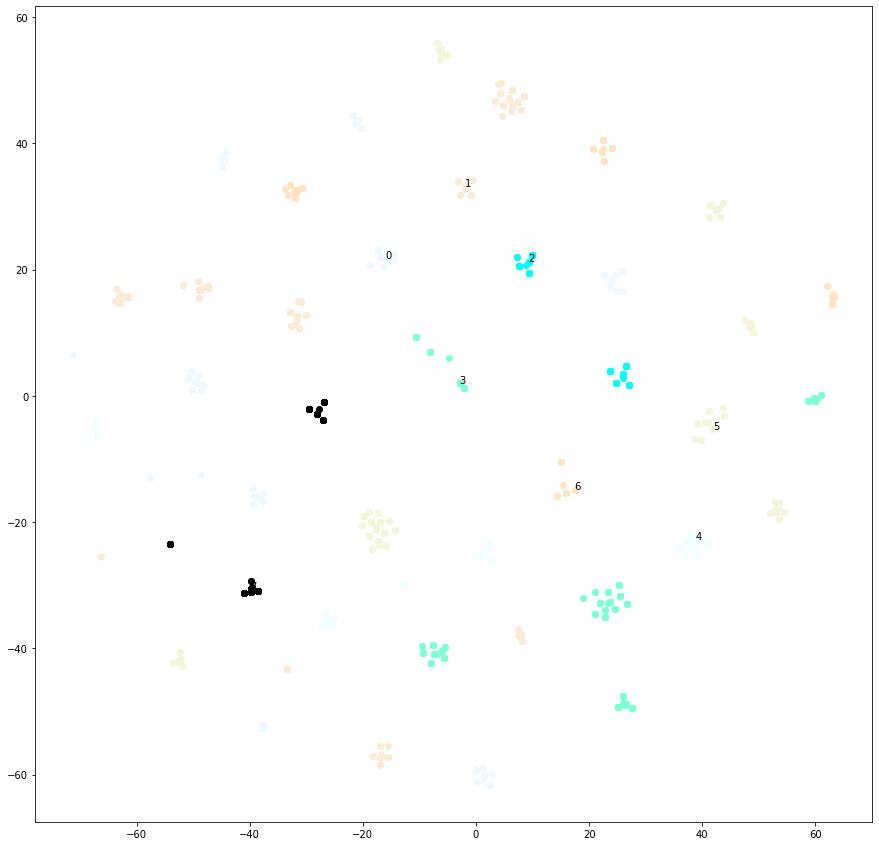

In [ ]:
k = 8
km = KMeans(k)
res = km.fit_predict(all_msg)
tsne = TSNE(2)
tsne_msg = tsne.fit_transform(all_msg)

plt.figure(figsize=(15,15))
for i, c in zip(range(k), mcolors.cnames):
  d = tsne_msg[res==i]
  plt.scatter(d[:, 0], d[:,1], label=i, color=c)
  plt.annotate(str(i), d[0])

In [ ]:
df1 = df[(df.non_blank_partition.isin([0,1])) & (df.correct)][['msg_1', 'probs_1', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_1':'msg', 'probs_1':'prob'})
df2 = df[(df.non_blank_partition.isin([0,2])) & (df.correct)][['msg_2', 'probs_2', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_2':'msg', 'probs_2':'prob'})
df2.p = 1-df2.p
msg_df = pd.concat([df1, df2])

df1 = df[df.non_blank_partition.isin([2])][['msg_1', 'probs_1', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_1':'msg', 'probs_1':'prob'})
df2 = df[df.non_blank_partition.isin([1])][['msg_2', 'probs_2', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_2':'msg', 'probs_2':'prob'})
df2.p = 1-df2.p
blank_msg_df = pd.concat([df1, df2])

In [ ]:
all_msg = np.array(msg_df.msg.tolist()).squeeze()
all_prob = np.array(msg_df.prob.tolist()).squeeze()
tsne_msg = TSNE(2).fit_transform(all_msg)

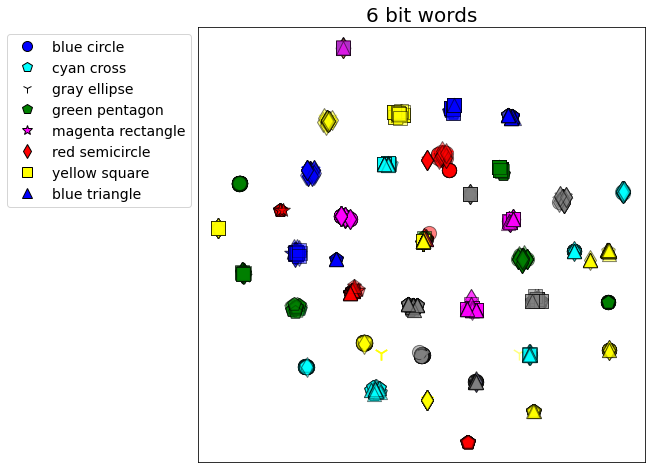

In [ ]:
shapes = ['circle', 'cross', 'ellipse', 'pentagon', 'rectangle', 'semicircle', 'square', 'triangle']
shapes_ = ['o',       'p',      "1",        "p",        "*",          "d",        "s",      "^"]
colors = ['blue', 'cyan', 'gray', 'green', 'magenta', 'red', 'yellow']

import matplotlib.lines as mlines
legend = []
for c, s, s_name in zip(['blue', 'cyan', 'gray', 'green', 'magenta', 'red', 'yellow', 'blue'],
                shapes_,
                shapes):
  legend.append(mlines.Line2D([], [], color=c, marker=s, linestyle='None',
                          markersize=10, label=f'{c} {s_name}', markeredgecolor='k'))

plt.figure(figsize=(8,8))
for s, s_ in zip(shapes, shapes_):
  for c in colors:
    d = tsne_msg[(msg_df["shape"]==s) & (msg_df["color"]==c)]
    plt.scatter(d[:, 0], d[:,1], label=f"{c} {s}", color=c, marker=s_, edgecolors="k", s=200, alpha=0.5)
plt.legend(handles=legend, bbox_to_anchor=(0, 1), fontsize=14)
plt.xticks([])
plt.yticks([])
plt.title("6 bit words", fontdict={'fontsize':20})
plt.show()

In [ ]:
from sklearn.linear_model import SGDClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,circle,cross,ellipse,pentagon,rectangle,semicircle,square,triangle
f1_comp,0.584746,0.469880,0.000000,0.438040,0.000000,0.489607,0.000000,0.420601
recall_comp,0.482517,0.745223,0.000000,0.603175,0.000000,0.716216,0.000000,0.388889
precision_comp,0.741935,0.343109,0.000000,0.343891,0.000000,0.371930,0.000000,0.457944
f1_not_comp,0.664430,0.730159,0.405530,0.336283,0.211640,0.362550,0.303030,0.329670
recall_not_comp,0.692308,0.732484,0.323529,0.301587,0.172414,0.614865,0.263158,0.238095
precision_not_comp,0.638710,0.727848,0.543210,0.380000,0.273973,0.257062,0.357143,0.535714



comp feature importances [ | 0.00  | 0.20  | 0.42  | 0.31  | 0.00  | 0.08]

not comp feature importances [ | 0.11  | 0.15  | 0.32  | 0.23  | 0.10  | 0.10]

average f1 comp 0.3003592344093511
average f1 not comp 0.4179115056569361


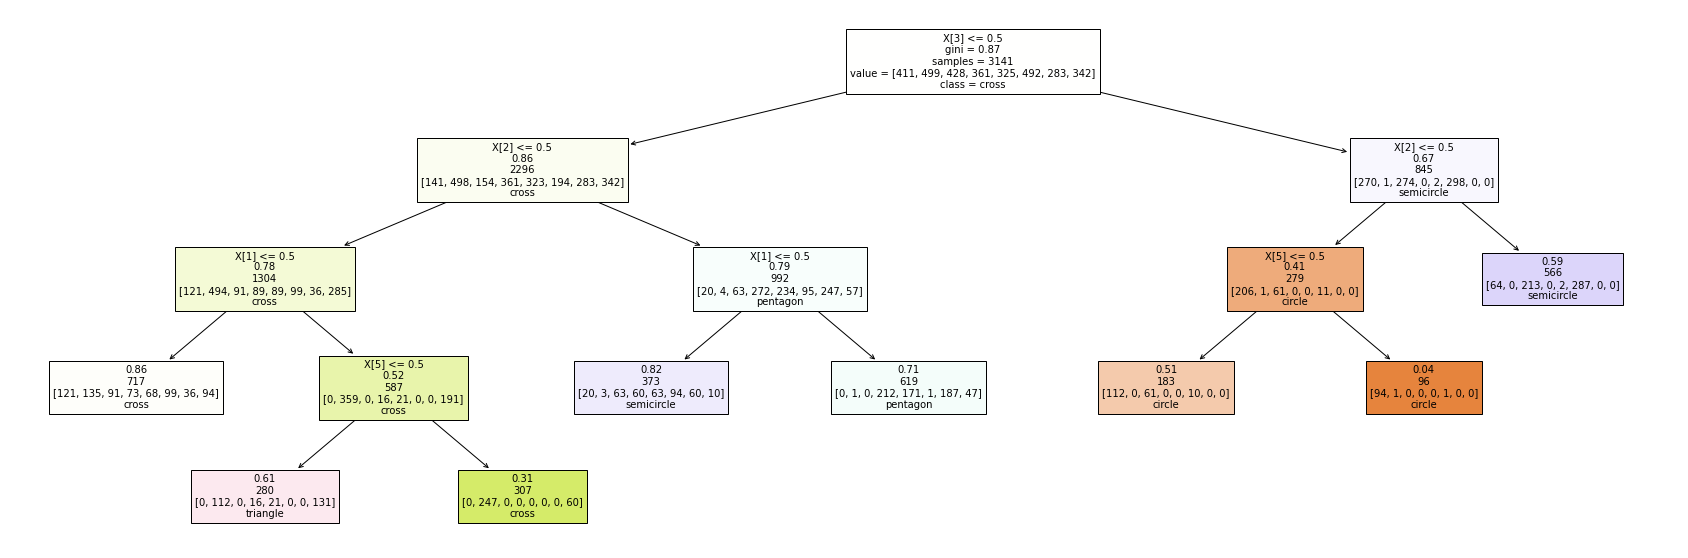

In [ ]:
df_ = msg_df.dropna(axis=0, subset=["shape"])
y = df_["shape"]
X = np.array(df_.msg.tolist()).squeeze()
X_t, X_te, y_t, y_te = train_test_split(X[:, :], y, test_size=0.25)

tree = DecisionTreeClassifier(max_leaf_nodes=8)
tree.fit(X_t, y_t)
y_ = tree.predict(X_te)

tree_no_limit = DecisionTreeClassifier()
tree_no_limit.fit(X_t, y_t)
y_no_limit = tree_no_limit.predict(X_te)

res = pd.DataFrame(np.vstack([f1_score(y_te, y_, average=None),
                              recall_score(y_te, y_, average=None),
                              precision_score(y_te, y_, average=None),
                              
                              f1_score(y_te, y_no_limit, average=None),
                              recall_score(y_te, y_no_limit, average=None),
                              precision_score(y_te, y_no_limit, average=None)]),
                    index=["f1_comp", "recall_comp", "precision_comp", "f1_not_comp", "recall_not_comp", "precision_not_comp"], columns=tree.classes_)
display(res)
print(f"\ncomp feature importances", tree.feature_importances_)
print(f"\nnot comp feature importances", tree_no_limit.feature_importances_)

print("\naverage f1 comp", res.loc['f1_comp'].mean())
print("average f1 not comp", res.loc['f1_not_comp'].mean())

plt.figure(figsize=(30,10))
plt.title("comp tree")
plot_tree(tree, fontsize=10, filled=True, class_names=tree.classes_, label='root', precision=2 )
plt.show()

,blue,cyan,gray,green,magenta,red,yellow
f1_comp,0.865248,0.890244,0.877493,0.897833,0.885135,0.628000,0.921569
recall_comp,0.767296,0.802198,0.781726,0.833333,0.845161,0.975155,0.854545
precision_comp,0.991870,1.000000,1.000000,0.973154,0.929078,0.463127,1.000000
f1_not_comp,0.865248,0.890244,0.877493,0.897833,0.894198,0.636183,0.921569
recall_not_comp,0.767296,0.802198,0.781726,0.833333,0.845161,0.993789,0.854545
precision_not_comp,0.991870,1.000000,1.000000,0.973154,0.949275,0.467836,1.000000



comp feature importances [ | 0.17  | 0.00  | 0.12  | 0.00  | 0.33  | 0.38]

not comp feature importances [ | 0.16  | 0.03  | 0.11  | 0.03  | 0.30  | 0.37]

average f1 comp 0.8522173695436905
average f1 not comp 0.8546810437819461


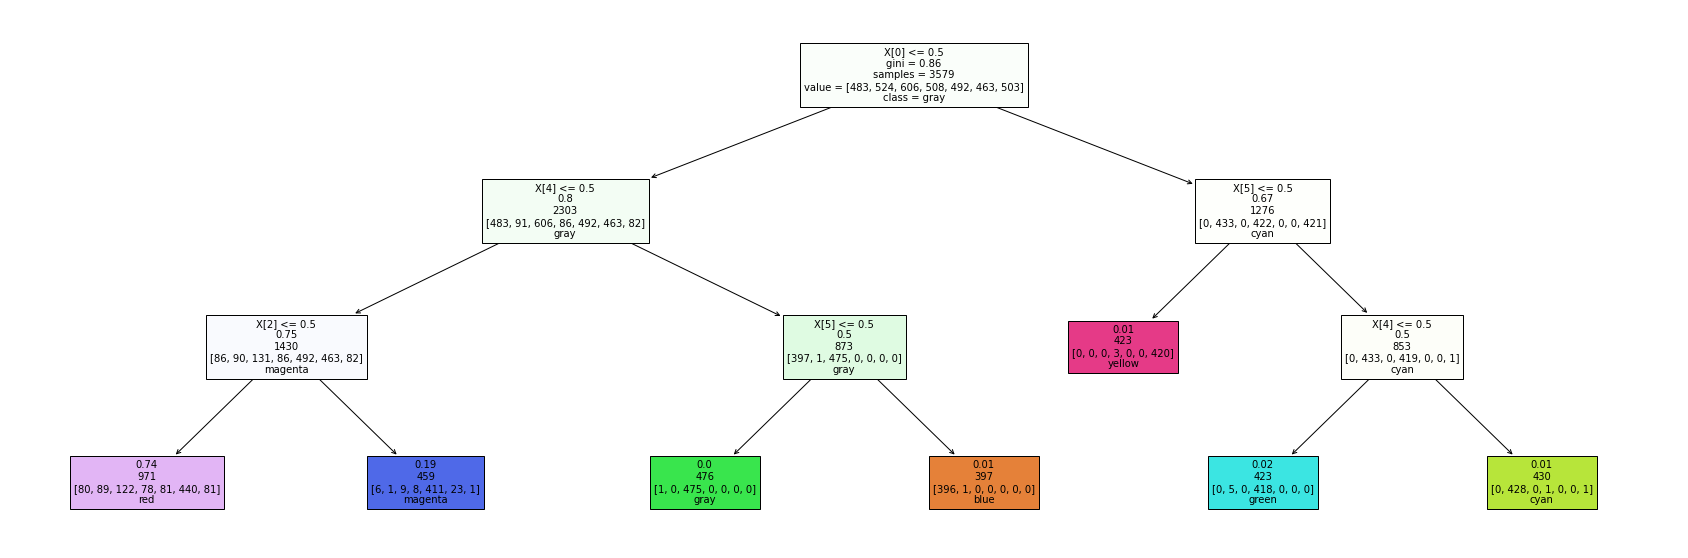

In [ ]:
df_ = msg_df.dropna(axis=0, subset=["color"])
y = df_["color"]
X = np.array(df_.msg.tolist()).squeeze()
X_t, X_te, y_t, y_te = train_test_split(X[:, :], y, test_size=0.25)

tree = DecisionTreeClassifier(max_leaf_nodes=7)
tree.fit(X_t, y_t)
y_ = tree.predict(X_te)

tree_no_limit = DecisionTreeClassifier()
tree_no_limit.fit(X_t, y_t)
y_no_limit = tree_no_limit.predict(X_te)

res = pd.DataFrame(np.vstack([f1_score(y_te, y_, average=None),
                              recall_score(y_te, y_, average=None),
                              precision_score(y_te, y_, average=None),
                              
                              f1_score(y_te, y_no_limit, average=None),
                              recall_score(y_te, y_no_limit, average=None),
                              precision_score(y_te, y_no_limit, average=None)]),
                    index=["f1_comp", "recall_comp", "precision_comp", "f1_not_comp", "recall_not_comp", "precision_not_comp"], columns=tree.classes_)
display(res)
print(f"\ncomp feature importances", tree.feature_importances_)
print(f"\nnot comp feature importances", tree_no_limit.feature_importances_)

print("\naverage f1 comp", res.loc['f1_comp'].mean())
print("average f1 not comp", res.loc['f1_not_comp'].mean())

plt.figure(figsize=(30,10))
plt.title("comp tree")
plot_tree(tree, fontsize=10, filled=True, class_names=tree.classes_, label='root', precision=2 )
plt.show()

In [ ]:
df_ = msg_df.dropna(axis=0, subset=["color", "shape"])
y = df_["color"]+df_["shape"]
X = np.array(df_.msg.tolist()).squeeze()
X_t, X_te, y_t, y_te = train_test_split(X[:, :], y, test_size=0.25)

tree = DecisionTreeClassifier(max_leaf_nodes=7*8)
tree.fit(X_t, y_t)
y_ = tree.predict(X_te)

tree_no_limit = DecisionTreeClassifier()
tree_no_limit.fit(X_t, y_t)
y_no_limit = tree_no_limit.predict(X_te)

res = pd.DataFrame(np.vstack([f1_score(y_te, y_, average=None),
                              recall_score(y_te, y_, average=None),
                              precision_score(y_te, y_, average=None),
                              
                              f1_score(y_te, y_no_limit, average=None),
                              recall_score(y_te, y_no_limit, average=None),
                              precision_score(y_te, y_no_limit, average=None)]),
                    index=["f1_comp", "recall_comp", "precision_comp", "f1_not_comp", "recall_not_comp", "precision_not_comp"], columns=tree.classes_)
display(res)
print(f"\ncomp feature importances", tree.feature_importances_)
print(f"\nnot comp feature importances", tree_no_limit.feature_importances_)

print("average f1 comp", res.loc['f1_comp'].mean())
print("average f1 not comp", res.loc['f1_not_comp'].mean())

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,bluecross,blueellipse,bluepentagon,bluerectangle,bluesemicircle,bluesquare,bluetriangle,cyancircle,cyancross,cyanpentagon,cyanrectangle,cyansemicircle,cyansquare,cyantriangle,graycircle,graycross,grayellipse,graypentagon,grayrectangle,graysemicircle,graysquare,graytriangle,greencircle,greencross,greenellipse,greenpentagon,greenrectangle,greensemicircle,greensquare,magentacircle,magentaellipse,magentapentagon,magentarectangle,magentasemicircle,magentasquare,magentatriangle,redcircle,redcross,redellipse,redpentagon,redrectangle,redsemicircle,redtriangle,yellowcircle,yellowcross,yellowellipse,yellowpentagon,yellowsemicircle,yellowsquare,yellowtriangle
f1_comp,0.571429,0.0,0.0,0.0,0.528302,0.400000,0.0,0.792453,0.221106,0.0,0.528302,0.736842,0.0,0.0,0.666667,0.619718,0.457143,0.160000,0.487805,0.0,0.0,0.0,0.837209,0.884615,0.0,0.0,0.415094,0.666667,0.0,0.436364,0.0,0.0,0.0,0.0,0.064516,0.200000,0.266667,0.666667,0.647059,0.250000,0.487805,0.0,0.0,0.727273,0.818182,0.416667,0.0,0.372093,0.731707,0.827586
recall_comp,0.705882,0.0,0.0,0.0,0.823529,0.500000,0.0,0.750000,0.916667,0.0,0.823529,0.636364,0.0,0.0,0.923077,0.687500,0.400000,0.111111,0.555556,0.0,0.0,0.0,0.900000,0.793103,0.0,0.0,0.578947,0.833333,0.0,0.705882,0.0,0.0,0.0,0.0,0.142857,0.307692,0.166667,0.500000,0.785714,0.166667,0.500000,0.0,0.0,0.800000,0.750000,0.333333,0.0,0.347826,0.937500,0.750000
precision_comp,0.480000,0.0,0.0,0.0,0.388889,0.333333,0.0,0.840000,0.125714,0.0,0.388889,0.875000,0.0,0.0,0.521739,0.564103,0.533333,0.285714,0.434783,0.0,0.0,0.0,0.782609,1.000000,0.0,0.0,0.323529,0.555556,0.0,0.315789,0.0,0.0,0.0,0.0,0.041667,0.148148,0.666667,1.000000,0.550000,0.500000,0.476190,0.0,0.0,0.666667,0.900000,0.555556,0.0,0.400000,0.600000,0.923077
f1_not_comp,0.571429,0.0,0.0,0.0,0.528302,0.400000,0.0,0.792453,0.221106,0.0,0.528302,0.736842,0.0,0.0,0.666667,0.619718,0.457143,0.160000,0.487805,0.0,0.0,0.0,0.837209,0.884615,0.0,0.0,0.415094,0.666667,0.0,0.436364,0.0,0.0,0.0,0.0,0.064516,0.200000,0.266667,0.666667,0.647059,0.250000,0.487805,0.0,0.0,0.727273,0.818182,0.416667,0.0,0.372093,0.731707,0.827586
recall_not_comp,0.705882,0.0,0.0,0.0,0.823529,0.500000,0.0,0.750000,0.916667,0.0,0.823529,0.636364,0.0,0.0,0.923077,0.687500,0.400000,0.111111,0.555556,0.0,0.0,0.0,0.900000,0.793103,0.0,0.0,0.578947,0.833333,0.0,0.705882,0.0,0.0,0.0,0.0,0.142857,0.307692,0.166667,0.500000,0.785714,0.166667,0.500000,0.0,0.0,0.800000,0.750000,0.333333,0.0,0.347826,0.937500,0.750000
precision_not_comp,0.480000,0.0,0.0,0.0,0.388889,0.333333,0.0,0.840000,0.125714,0.0,0.388889,0.875000,0.0,0.0,0.521739,0.564103,0.533333,0.285714,0.434783,0.0,0.0,0.0,0.782609,1.000000,0.0,0.0,0.323529,0.555556,0.0,0.315789,0.0,0.0,0.0,0.0,0.041667,0.148148,0.666667,1.000000,0.550000,0.500000,0.476190,0.0,0.0,0.666667,0.900000,0.555556,0.0,0.400000,0.600000,0.923077



comp feature importances [ | 0.05  | 0.21  | 0.25  | 0.20  | 0.14  | 0.16]

not comp feature importances [ | 0.05  | 0.21  | 0.25  | 0.20  | 0.14  | 0.16]
average f1 comp 0.3177187154541081
average f1 not comp 0.3177187154541081


blanks

In [ ]:
blank_msg_df["blank"] = True
msg_df['blank'] = False
df_ = pd.concat([blank_msg_df, msg_df]).sample(frac=1)
y = df_["blank"]
X = np.array(df_.msg.tolist()).squeeze()
X_t, X_te, y_t, y_te = train_test_split(X[:, :], y, test_size=0.25)
tree = DecisionTreeClassifier()
tree.fit(X_t, y_t)
y_ = tree.predict(X_te)
y_p = tree.predict_proba(X_te)[:,1]
res = pd.DataFrame(np.vstack([f1_score(y_te, y_, average=None),
                              recall_score(y_te, y_, average=None),
                              precision_score(y_te, y_, average=None)]),
                    index=["f1", "recall", "precision"], columns=tree.classes_)
display(res)
print("auc score", roc_auc_score(y_te, y_p))
print(f"prior:{y.mean():.3f}")
print(f"\nfeature importances", tree.feature_importances_)

,False,True
f1,0.585917,0.512918
recall,0.663982,0.450601
precision,0.524277,0.595238


auc score 0.5631383572435281
prior:0.506

feature importances [ | 0.21  | 0.12  | 0.12  | 0.14  | 0.20  | 0.21]


corrects

In [ ]:
df1_ = df[(df.non_blank_partition.isin([0,1]))][['msg_1', 'probs_1', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_1':'msg', 'probs_1':'prob'})
df2_ = df[(df.non_blank_partition.isin([0,2]))][['msg_2', 'probs_2', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_2':'msg', 'probs_2':'prob'})
df2_.p = 1-df2_.p
msg_df_ = pd.concat([df1_, df2_])

In [ ]:
blank_msg_df["blank"] = True
msg_df_['blank'] = False
df_ = pd.concat([blank_msg_df, msg_df_]).sample(frac=1)
y = df_["correct"]
X = np.array(df_.msg.tolist()).squeeze()
X_t, X_te, y_t, y_te = train_test_split(X[:, :], y, test_size=0.25)
tree = DecisionTreeClassifier()
tree.fit(X_t, y_t)
y_ = tree.predict(X_te)
y_p = tree.predict_proba(X_te)[:,1]
res = pd.DataFrame(np.vstack([f1_score(y_te, y_, average=None),
                              recall_score(y_te, y_, average=None),
                              precision_score(y_te, y_, average=None)]),
                    index=["f1", "recall", "precision"], columns=tree.classes_)
display(res)
print("auc score", roc_auc_score(y_te, y_p))
print(f"prior:{y.mean():.3f}")
print(f"\nfeature importances", tree.feature_importances_)

,False,True
f1,0.031569,0.823907
recall,0.016457,0.989056
precision,0.386364,0.706019


auc score 0.5786658823871031
prior:0.696

feature importances [ | 0.08  | 0.25  | 0.18  | 0.06  | 0.15  | 0.29]
